<a href="https://colab.research.google.com/github/acate/image_classifier/blob/main/auto_img_cls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 0: Init the AutoML program

Run the cell to import necessary modules and training code.

See if you can figure out the name of the image classification neural network model that we'll be using -- it's buried deep in the code of the first code block below.

In [ ]:
import numpy as np
import os
import contextlib
import tensorflow as tf
import tempfile
import shutil
import zipfile
from PIL import Image
import numpy as np
import zipfile


@contextlib.contextmanager
def _tempdir():
    dirpath = tempfile.mkdtemp()
    yield dirpath
    shutil.rmtree(dirpath)


class ImageClassifier:
    def __init__(self):
        self.model = None
        self.image_size = None
        self.class_names = None

    def train(self, dataset_dir, batch_size=32, epochs=1, image_size=(160, 160), learning_rate=0.0001):
        # Step1: Data prep
        train_dataset = tf.keras.utils.image_dataset_from_directory(dataset_dir,
                                                                    seed=1337,
                                                                    validation_split=0.2,
                                                                    batch_size=batch_size,
                                                                    subset='training',
                                                                    image_size=image_size)
        validation_dataset = tf.keras.utils.image_dataset_from_directory(dataset_dir,
                                                                         seed=1337,
                                                                         validation_split=0.2,
                                                                         batch_size=batch_size,
                                                                         subset='validation',
                                                                         image_size=image_size)
        class_names = train_dataset.class_names

        print('Number of trian batches: %d' %
              tf.data.experimental.cardinality(train_dataset))
        print('Number of validation batches: %d' %
              tf.data.experimental.cardinality(validation_dataset))
        train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
        validation_dataset = validation_dataset.prefetch(
            buffer_size=tf.data.AUTOTUNE)

        # Step2: Model Architecture

        # Skip the data_augmentation because
        # https://stackoverflow.com/questions/69955838/saving-model-on-tensorflow-2-7-0-with-data-augmentation-layer
        #
        # data_augmentation = tf.keras.Sequential([
        #     tf.keras.layers.RandomFlip('horizontal'),
        #     tf.keras.layers.RandomRotation(0.2),
        # ])
        preprocess_input = tf.keras.applications.inception_v3.preprocess_input
        image_shape = image_size + (3,)
        base_model = tf.keras.applications.InceptionV3(input_shape=image_shape,
                                                       include_top=False,
                                                       weights='imagenet')
        base_model.trainable = True
        fine_tune_at = 100
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False

        global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
        inputs = tf.keras.Input(shape=image_shape)
        x = inputs
        # x = data_augmentation(x)
        x = preprocess_input(x)
        x = base_model(x, training=False)
        x = global_average_layer(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(len(class_names))(x)
        outputs = tf.nn.softmax(x)
        model = tf.keras.Model(inputs, outputs)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=False),
            metrics=['accuracy'])
        model.summary()

        # Step 3: Start training
        history = model.fit(train_dataset,
                            epochs=epochs,
                            validation_data=validation_dataset)

        # Step 4: Evaluation
        if validation_dataset:
            loss, accuracy = model.evaluate(validation_dataset)
            print('Test accuracy :', accuracy)

            # Retrieve a batch of images from the test set
            image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
            predictions = model.predict_on_batch(image_batch)

            # Apply softmax and argmax to find the most possible class
            predictions = model.predict_on_batch(image_batch)
            predictions = tf.math.argmax(predictions, axis=-1)
            print('Predictions:\n', predictions.numpy())
            print('Labels:\n', label_batch)

        self.model = model
        self.class_names = class_names
        self.image_size = (160, 160)
        image_size = (160, 160)

        return history

    def save(self, modelfile):
        with _tempdir() as modelpath:
            self.model.save(modelpath)
            with open(f'{modelpath}/class_names.txt', 'w') as f:
                for class_name in self.class_names:
                    print(class_name, file=f)

            with zipfile.ZipFile(modelfile, 'w', zipfile.ZIP_DEFLATED) as zf:
                for dirname, subdirs, files in os.walk(modelpath):
                    arc_dirname = dirname[len(modelpath):]
                    print(f'dir : {arc_dirname}/')
                    zf.write(dirname, arc_dirname)
                    for filename in files:
                        print(f'file: {arc_dirname}/{filename}')
                        zf.write(os.path.join(dirname, filename),
                                 os.path.join(arc_dirname, filename))

    def load(self, modelfile):
        with _tempdir() as dirpath:
            with zipfile.ZipFile(modelfile, 'r') as zip_ref:
                zip_ref.extractall(dirpath)
            model = tf.keras.models.load_model(dirpath)
            with open(f"{dirpath}/class_names.txt") as f:
                class_names = f.readlines()
            class_names = [class_name.strip() for class_name in class_names]

        self.image_size = (160, 160)
        self.class_names = (class_names)
        self.model = model

    def predict(self, img_path):
        with Image.open(img_path) as image:
            image = image.resize(self.image_size).convert("RGB")
            x = tf.keras.preprocessing.image.img_to_array(image)
            x = tf.expand_dims(x, 0)
        result = self.model(x)
        result = tf.squeeze(result)
        cls_idx = int(tf.math.argmax(result, axis=-1))
        cls = self.class_names[cls_idx]
        return (cls, result.numpy())

    def predict_img(self, image):
        image = image.resize(self.image_size).convert("RGB")
        x = tf.keras.preprocessing.image.img_to_array(image)
        x = tf.expand_dims(x, 0)
        result = self.model(x)
        result = tf.squeeze(result)
        cls_idx = int(tf.math.argmax(result, axis=-1))
        cls = self.class_names[cls_idx]
        return (cls, result.numpy())


# Step 1: Prepare the dataset

The dataset should be a 'zip' file with the following format.

```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```  

Please see the document in tensorflow
https://www.tensorflow.org/tutorials/load_data/images


After the step 1, the variable of `dataset_dir` should be set as the directory of your dataset.

## Make your own dataset


1. Make a folder named "my_images".

1. Inside of that, make several subfolders named after the types of images that you plan to fill them with: "kitten" "wombat" "spatula" etc.

1. (This step is actually the time-consuming, but fun, one:) Using Google Images or any other legitimate source, find roughly 20 examples of each type of image, and put them in the subfolders.  [Or! Find a small, well-labeled dataset that includes images pre-organized into folders, like the "Animals 151" dataset available at https://www.kaggle.com/datasets/sharansmenon/animals141]

1. `zip` the "my_images" folder so that you have a file named "my_images.zip"

1. Click on the icon of a folder that is on the left side of this page.

1. Drag and drop your "my_images.zip" file into the empty space next to the (now orange) folder icon.

1. Run the below code cell to unzip and set the variable `dataset_dir`

In [ ]:
_DATASET_FILE = '/content/my_images.zip'

import os
import tempfile

with zipfile.ZipFile(_DATASET_FILE, 'r') as zip_ref:
    zip_ref.extractall(".")

basename = os.path.basename(_DATASET_FILE)
dataset_dir, ext = os.path.splitext(basename)

print(f"dataset dir: {dataset_dir}")

dataset dir: my_images


# Step 2: Train

Now that we have dataset, we will start to train a model based on the dataset.

There are three parameter we can adjust
1. `EPOCHS`: how many times we should go through the whole dataset
2. `BATCH_SIZE`: how many data we should update the weights
3. `LEARNING_RATE`: how big step we should update the weights for each batch

In the training process, we will split the dataset into two parts (the code will do this for you automatically)
- Training set (80%): use to train and update the weight
- Validation set (20%): use to validate the model

The goal for each experiment is to get the best accuracy in the validation dataset.

In [ ]:
EPOCHS = 2
BATCH_SIZE = 25
LEARNING_RATE = 0.001

classifier = ImageClassifier()
history = classifier.train(dataset_dir, epochs=EPOCHS, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE)

Found 60 files belonging to 3 classes.
Using 48 files for training.
Found 60 files belonging to 3 classes.
Using 12 files for validation.
Number of trian batches: 2
Number of validation batches: 1
87910968/87910968 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784

# Step 3: Predict: Use an image to test the model

1. Locate one of the extra images that you found but did not include in the "my_images" folder.  

1. Drag and drop that image file into the file area at left (after clicking the folder icon to open it).

1. Once that image file appears listed in the file area at left, right-click on its name, and select "Copy path"

1. Next, in the code block below, replace the characters between the quotes in "/content/three_tennis_balls_S3958609111_St25_G7.5.263.png" by highlighting them and then pasting the path you just copied.  This should produce the line

`_IMG_PATH="/content/[your image file name]"`

Finally, run the code block and examine the output.  

You can do this for several different images to see how well your model works.

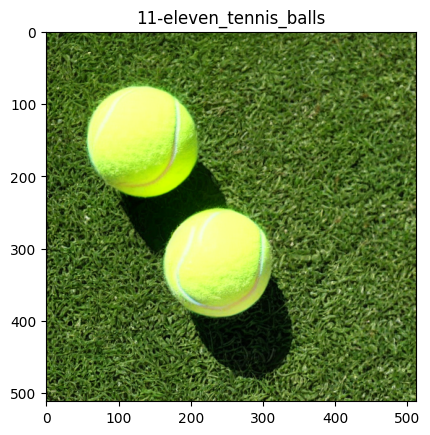

predict: 11-eleven_tennis_balls
class_names: ['01-one_tennis_ball', '06-six_tennis_balls', '11-eleven_tennis_balls']
probability: [0.46600825 0.0424844  0.4915073 ]


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img

_IMG_PATH="/content/three_tennis_balls_S3958609111_St25_G7.5.263.png"

image = img.imread(_IMG_PATH)
cls, probs = classifier.predict(_IMG_PATH)

plt.title(cls)
plt.imshow(image)
plt.show()

print(f"predict: {cls}")
print(f"class_names: {classifier.class_names}")
print(f"probability: {probs}")